In [15]:
'''Feature Engineering
Transformar datos crudos en variables/features que ayuden al modelo a aprender mejor los patrones
En series de tiempo:
    - extraer estructura temporal
    - agregar memoria (lags)
    - agregar contexto (rolling stats)
    - codificar periodicidad (cíclicas)
    - incorporar señales externas (feriados, clima, etc)
PENDIENTE:
    - hacer análisis de redundancia de features
'''
# .\venv\Scripts\Activate

'Feature Engineering\nTransformar datos crudos en variables/features que ayuden al modelo a aprender mejor los patrones\nEn series de tiempo:\n    - extraer estructura temporal\n    - agregar memoria (lags)\n    - agregar contexto (rolling stats)\n    - codificar periodicidad (cíclicas)\n    - incorporar señales externas (feriados, clima, etc)\nPENDIENTE:\n    - hacer análisis de redundancia de features\n'

In [ ]:
import pandas as pd
import numpy as np

# Features temporales/de calendario
def create_time_features(df):
    df = df.copy()
    
    # Básicas
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    
    # Binarias
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)

    return df

# features de lags
def create_lag_features(df, target_col, lags):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

# features de ventanas móviles
def create_rolling_features(df, target_col, windows):
    """
    Rolling features con shift(1) para evitar data leakage.
    """
    df = df.copy()
    shifted_target = df[target_col].shift(1)
    for window in windows:
        df[f'rolling_mean_{window}'] = shifted_target.rolling(window).mean()
        df[f'rolling_std_{window}'] = shifted_target.rolling(window).std()
        df[f'rolling_min_{window}'] = shifted_target.rolling(window).min()
        df[f'rolling_max_{window}'] = shifted_target.rolling(window).max()
    return df


    

# encoding cilico
def create_cyclical_features(df):
    df = df.copy()

    # hora (0-23)
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

    # mes (1-12)
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)

    # día de la semana (0-6)
    df['dayofweek_sin'] = np.sin(2*np.pi*df['dayofweek']/7)
    df['dayofweek_cos'] = np.cos(2*np.pi*df['dayofweek']/7)

    return df

# features de festivos USA
def add_holidays(df):
    df = df.copy()

    from pandas.tseries.holiday import USFederalHolidayCalendar
    
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    
    # 1. Feature básica
    df['is_holiday'] = df.index.isin(holidays).astype(int)
    
    # 2. Ventana de festivo (simple y efectiva)
    # Marca +-3 días alrededor de festivos
    holiday_window = set()
    for holiday in holidays:
        for offset in range(-3, 4):  # -3 a +3 días
            holiday_window.add(holiday + pd.Timedelta(days=offset))
    
    df['near_holiday'] = df.index.isin(holiday_window).astype(int)
    
    # 3. Tipo de festivo (implementación pendiente)
    # Algunos festivos impactan más que otros
    # major_holidays = ['New Year', 'Christmas', 'Thanksgiving']
    
    return df

# features de cambio. velocidad y aceleración en el consumo
def create_change_features(df):
    df = df.copy()
    
    # Cambios absolutos
    df['diff_1h'] = df['lag_1'] - df['lag_2']      # Cambio última hora
    df['diff_24h'] = df['lag_1'] - df['lag_24']    # Cambio vs ayer
    df['diff_168h'] = df['lag_1'] - df['lag_168']  # Cambio vs semana pasada
    
    # Cambios porcentuales
    df['pct_change_1h'] = (df['lag_1'] - df['lag_2']) / df['lag_2']
    df['pct_change_24h'] = (df['lag_1'] - df['lag_24']) / df['lag_24']
    df['pct_change_168h'] = (df['lag_1'] - df['lag_168']) / df['lag_168']
    
    # Aceleración (cambio del cambio)
    df['acceleration_1h'] = df['diff_1h'] - (df['lag_2'] - df['lag_3'])
    
    # # Tendencia (promedio de cambios recientes)
    # df['trend_short'] = (df['diff_1h'] + (df['lag_2'] - df['lag_3']) + (df['lag_3'] - df['lag_4'])) / 3
    
    # Manejar divisiones por cero
    df = df.replace([np.inf, -np.inf], np.nan)
    
    return df


# distintos tipos de volatilidad. útil para ver la incerteza en períodos
def create_volatility_features(df, target_col, fh=24, windows=[24, 168]):
    """
    Features de volatilidad (variabilidad del consumo).
    """
    df = df.copy()
    
    # Opción 1: Rolling Standard Deviation (clásica)
    for window in windows:
        df[f'volatility_std_{window}'] = (
            df[target_col].shift(1).rolling(window).std()
        )
    
    # Opción 2: Coefficient of Variation (volatilidad normalizada)
    # CV = std / mean (útil para comparar periodos con diferentes niveles)
    for window in windows:
        rolling_mean = df[target_col].shift(1).rolling(window).mean()
        rolling_std = df[target_col].shift(1).rolling(window).std()
        df[f'volatility_cv_{window}'] = rolling_std / rolling_mean
    
    # Opción 3: Range (max - min)
    for window in windows:
        rolling_max = df[target_col].shift(1).rolling(window).max()
        rolling_min = df[target_col].shift(1).rolling(window).min()
        df[f'volatility_range_{window}'] = rolling_max - rolling_min
    
    # Opción 4: Volatilidad de cambios (más sensible)
    # Desviación estándar de los cambios horarios
    df['change_1h'] = df[target_col].shift(fh).diff(1)
    for window in windows:
        df[f'volatility_changes_{window}'] = (
            df['change_1h'].shift(1).rolling(window).std()
        )
    
    # Opción 5: Varianza interquartil (robusta a outliers)
    for window in windows:
        q75 = df[target_col].shift(1).rolling(window).quantile(0.75)
        q25 = df[target_col].shift(1).rolling(window).quantile(0.25)
        df[f'volatility_iqr_{window}'] = q75 - q25
    
    return df




# Pipeline de feature engineering:
# se añade forecast_horizon=N para predecir el consumo dentro de N horas
def engineer_features(df, target_col='PJME_MW', forecast_horizon=24):
    
    df = create_time_features(df)
    df = create_cyclical_features(df)
    df = add_holidays(df)

    if forecast_horizon == 1:
        # Configuración actual - t+1
        lags = [1, 2, 3, 24, 25, 168, 169]
    else:
        # Para 24hs o más - el lag más cercano disponible es el horizonte mismo
        h = forecast_horizon
        lags = [h, h+1, h+2,       # equivalente a lag_1,2,3 pero desplazados
                h+23, h+24,         # equivalente a lag_24,25
                168, 169]           # semana pasada siempre disponible

    df = create_lag_features(df, target_col, lags=lags)
    df = create_rolling_features(df, target_col, windows=[24, 168])

    # Re-calcular change features con los lags correctos
    min_lag = min(lags)
    df[f'diff_24h']  = df[f'lag_{min_lag}'] - df[f'lag_{min_lag+23}']
    df[f'diff_168h'] = df[f'lag_{min_lag}'] - df['lag_168']
    df['pct_change_24h']  = df['diff_24h']  / df[f'lag_{min_lag+23}']
    df['pct_change_168h'] = df['diff_168h'] / df['lag_168']

    df = create_volatility_features(df, target_col, fh=forecast_horizon, windows=[24, 168])
    df['expanding_mean'] = df[target_col].shift(1).expanding().mean()

    # El target se desplaza según el horizonte
    df[target_col] = df[target_col].shift(-forecast_horizon)

    df = df.dropna()
    return df

0.9747653713007711
0.8913873649505104
NaNs antes de dropna: 0
Filas después de dropna: 145173

SPLITTING DATA
Gap Train→Val: 1 days 01:00:00 ✓
Gap Val→Test:  1 days 01:00:00 ✓

✓ Saved datasets to ..\data\processed


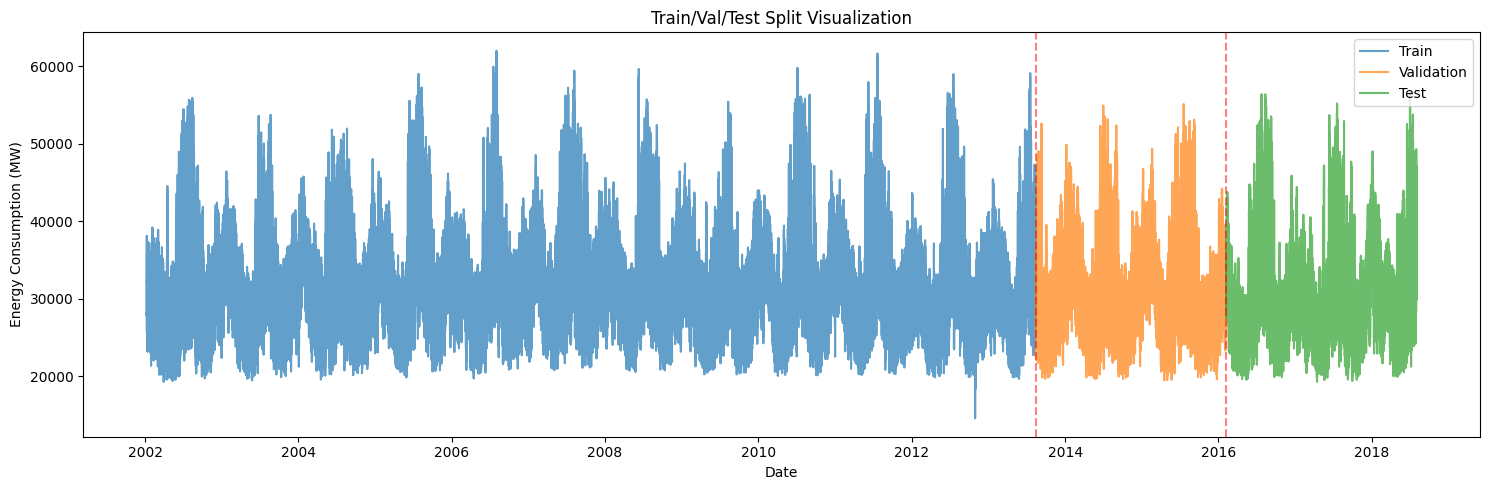

In [20]:
from pathlib import Path

df_raw = pd.read_csv('../data/raw/PJME_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
df_raw = df_raw.sort_index()
print(df_raw['PJME_MW'].autocorr(lag=1))
print(df_raw['PJME_MW'].autocorr(lag=24))

fh = 24
df_complete = engineer_features(df_raw, target_col='PJME_MW', forecast_horizon=fh)

# Verificar que no hay NaNs 
print(f"NaNs antes de dropna: {df_complete.isnull().sum().sum()}")
df_complete = df_complete.dropna()
print(f"Filas después de dropna: {len(df_complete)}")

# ==================
# SPLIT TEMPORAL
# ==================
print("\n" + "="*50)
print("SPLITTING DATA")
print("="*50)

# Definir proporciones
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
# TEST_RATIO = 0.15 (implícito)

# Calcular índices
n = len(df_complete)
train_end = int(n * TRAIN_RATIO)
val_end = train_end + int(n * VAL_RATIO)

# Gap para evitar leakage en el target
gap = fh  # 24 horas

train_df = df_complete.iloc[:train_end].copy()
val_df   = df_complete.iloc[train_end + gap : val_end].copy()
test_df  = df_complete.iloc[val_end + gap :].copy()

# El assert ahora verifica el gap real
assert (val_df.index[0] - train_df.index[-1]).total_seconds() / 3600 >= fh, \
    f"Train/Val gap menor a {fh}hs!"
assert (test_df.index[0] - val_df.index[-1]).total_seconds() / 3600 >= fh, \
    f"Val/Test gap menor a {fh}hs!"

print(f"Gap Train→Val: {(val_df.index[0] - train_df.index[-1])} ✓")
print(f"Gap Val→Test:  {(test_df.index[0] - val_df.index[-1])} ✓")

# ==================
# GUARDAR
# ==================
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

train_df.to_csv(output_dir / f'train_{fh}hr.csv')
val_df.to_csv(output_dir / f'val_{fh}hr.csv')
test_df.to_csv(output_dir / f'test_{fh}hr.csv')

# Guardar también dataset completo (por si acaso)
df_complete.to_csv(output_dir / f'complete_{fh}hr.csv')

print(f"\n✓ Saved datasets to {output_dir}")

# ==================
# VISUALIZACIÓN DEL SPLIT
# ==================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))

# Plot target en cada split con colores diferentes
ax.plot(train_df.index, train_df['PJME_MW'], label='Train', alpha=0.7)
ax.plot(val_df.index, val_df['PJME_MW'], label='Validation', alpha=0.7)
ax.plot(test_df.index, test_df['PJME_MW'], label='Test', alpha=0.7)

# Líneas verticales separadoras
ax.axvline(train_df.index[-1], color='red', linestyle='--', alpha=0.5)
ax.axvline(val_df.index[-1], color='red', linestyle='--', alpha=0.5)

ax.set_title('Train/Val/Test Split Visualization')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (MW)')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/train_val_test_split.png', dpi=150)
plt.show()

# print("\n✓ Split visualization saved")

In [18]:
print(df_complete.index.is_monotonic_increasing)


True


In [21]:
# ==================
# VERIFICACIÓN DETALLADA DE SPLITS
# ==================
print("\n" + "="*70)
print("VERIFICACIÓN DE SPLITS")
print("="*70)

print(f"\n{'Set':<12} {'Start':<20} {'End':<20} {'Samples':>10}")
print("-" * 70)
print(f"{'Train':<12} {str(train_df.index[0]):<20} {str(train_df.index[-1]):<20} {len(train_df):>10,}")
print(f"{'Validation':<12} {str(val_df.index[0]):<20} {str(val_df.index[-1]):<20} {len(val_df):>10,}")
print(f"{'Test':<12} {str(test_df.index[0]):<20} {str(test_df.index[-1]):<20} {len(test_df):>10,}")

# Verificar gaps
gap_train_val = (val_df.index[0] - train_df.index[-1]).total_seconds() / 3600
gap_val_test  = (test_df.index[0] - val_df.index[-1]).total_seconds() / 3600

print(f"\nGap Analysis:")
print(f"  Train → Val gap:  {gap_train_val:.1f} hours (expected >= {fh})")
print(f"  Val → Test gap:   {gap_val_test:.1f} hours (expected >= {fh})")

if gap_train_val >= fh and gap_val_test >= fh:
    print(f"  ✓ Gaps correctos (>= forecast_horizon de {fh}hs, sin leakage)")
else:
    print(f"  ⚠️ Warning: gap insuficiente, puede haber leakage en el target")

print(f"\nTransition points:")
print(f"  Last train sample:  {train_df.index[-1]}  →  target: t+{fh}h")
print(f"  First val sample:   {val_df.index[0]}")
print(f"  Last val sample:    {val_df.index[-1]}  →  target: t+{fh}h")
print(f"  First test sample:  {test_df.index[0]}")

print("\n" + "="*70)


VERIFICACIÓN DE SPLITS

Set          Start                End                     Samples
----------------------------------------------------------------------
Train        2002-01-08 02:00:00  2013-08-13 06:00:00     101,621
Validation   2013-08-14 07:00:00  2016-02-06 14:00:00      21,751
Test         2016-02-07 15:00:00  2018-08-02 00:00:00      21,753

Gap Analysis:
  Train → Val gap:  25.0 hours (expected >= 24)
  Val → Test gap:   25.0 hours (expected >= 24)
  ✓ Gaps correctos (>= forecast_horizon de 24hs, sin leakage)

Transition points:
  Last train sample:  2013-08-13 06:00:00  →  target: t+24h
  First val sample:   2013-08-14 07:00:00
  Last val sample:    2016-02-06 14:00:00  →  target: t+24h
  First test sample:  2016-02-07 15:00:00

